In [1]:
import os
import json
from collections import defaultdict

ROOT_DIR = "/mnt/raid10/ak-research-01/ak-research-01/codes/steer-vector/latentqa/1_feature_description/model"

def collect_results(root_dir: str):
    """
    Walk through all subdirectories under `root_dir`, look for
    'results/results.jsonl' in each, and compute average scores per layer.

    Returns:
        model_layer_scores: dict
            {
              "explainer_L01_L06_ckpt": {
                  16: 4.85,
                  17: 5.10,
                  ...
              },
              ...
            }
    """
    model_layer_scores = {}  # outer: model_name -> inner dict(layer->avg)

    # Iterate over immediate subdirectories in ROOT_DIR
    for model_name in os.listdir(root_dir):
        model_path = os.path.join(root_dir, model_name)
        if not os.path.isdir(model_path):
            continue

        results_path = os.path.join(model_path, "results", "results.jsonl")
        if not os.path.isfile(results_path):
            # no results file in this model folder
            continue

        # Aggregate sums and counts per layer
        layer_sum = defaultdict(float)
        layer_count = defaultdict(int)

        with open(results_path, "r", encoding="utf-8") as f:
            for line in f:
                line = line.strip()
                if not line:
                    continue
                try:
                    obj = json.loads(line)
                except json.JSONDecodeError:
                    continue

                layer = obj.get("layer")
                score = obj.get("score")

                if layer is None or score is None:
                    continue

                layer_sum[layer] += float(score)
                layer_count[layer] += 1

        # Compute averages for this model
        if layer_count:
            layer_avg = {
                layer: layer_sum[layer] / layer_count[layer]
                for layer in sorted(layer_count.keys())
            }
            model_layer_scores[model_name] = layer_avg

    return model_layer_scores


if __name__ == "__main__":
    scores_dict = collect_results(ROOT_DIR)

    # Print nicely
    for model_name, layer_dict in scores_dict.items():
        print(f"Model: {model_name}")
        for layer, avg_score in sorted(layer_dict.items()):
            print(f"  Layer {layer}: {avg_score:.4f}")
        print()

    # If you want to use the dictionary in code:
    # print(scores_dict)


Model: explainer_L01_L16_50%_ckpt
  Layer 1: 3.6400
  Layer 2: 3.1000
  Layer 4: 4.0000
  Layer 5: 3.2600
  Layer 6: 3.6800
  Layer 7: 4.2000
  Layer 8: 3.5600
  Layer 9: 3.6800
  Layer 10: 3.5000
  Layer 11: 3.2400
  Layer 12: 3.2200
  Layer 13: 3.2400
  Layer 14: 2.7400
  Layer 15: 3.0800
  Layer 16: 2.9000

Model: explainer_L12_L16_ckpt
  Layer 1: 3.1600
  Layer 2: 2.9400
  Layer 4: 3.6200
  Layer 5: 3.1600
  Layer 6: 3.7600
  Layer 7: 3.9600
  Layer 8: 3.3000
  Layer 9: 3.5400
  Layer 10: 3.4800
  Layer 11: 3.0000
  Layer 12: 3.0200
  Layer 13: 3.0400
  Layer 14: 2.8200
  Layer 15: 3.2400
  Layer 16: 2.9000

Model: qwen_explainer_L01_L31_ckpt
  Layer 1: 1.2000
  Layer 2: 1.3400
  Layer 4: 1.2000
  Layer 5: 1.4400
  Layer 6: 1.4200
  Layer 7: 1.2800
  Layer 8: 1.4400
  Layer 9: 1.3600
  Layer 10: 1.3800
  Layer 11: 1.3400
  Layer 12: 1.6800
  Layer 13: 1.4600
  Layer 14: 1.4400
  Layer 15: 1.5600
  Layer 16: 1.5400
  Layer 17: 1.4400
  Layer 18: 1.4200
  Layer 19: 1.4200
  Layer 20:

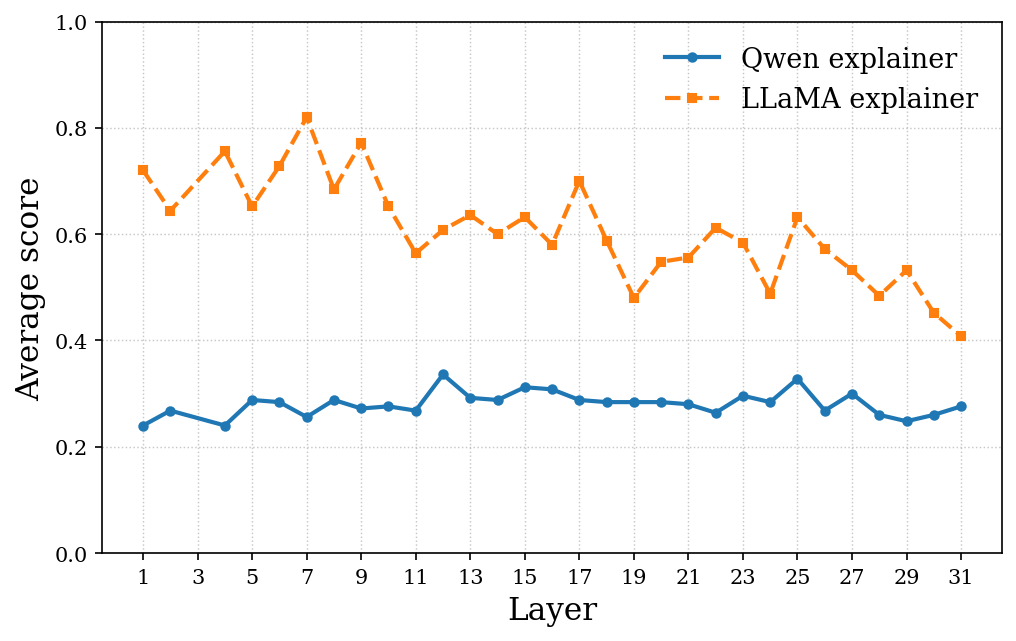

Saved figure to explainer_scores_vs_layer.pdf


In [10]:
import matplotlib.pyplot as plt

# for nicer fonts in papers
plt.rcParams.update({
    "font.family": "serif",
    "font.size": 14,
    "axes.labelsize": 15,
    "axes.titlesize": 15,
    "legend.fontsize": 13,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "figure.dpi": 150,
})

m1 = scores_dict['qwen_explainer_L01_L31_ckpt']
m2 = scores_dict['explainer_L01_L31_ckpt']

# sort layers
layers1 = sorted(m1.keys())
layers2 = sorted(m2.keys())

# normalize by 5 as you did (to get into [0,1] range)
y1 = [m1[l] / 5.0 for l in layers1]
y2 = [m2[l] / 5.0 for l in layers2]

fig, ax = plt.subplots(figsize=(7, 4.5))

ax.plot(
    layers1,
    y1,
    label="Qwen explainer",
    linewidth=2.0,
    marker="o",
    markersize=4,
)

ax.plot(
    layers2,
    y2,
    label="LLaMA explainer",
    linewidth=2.0,
    marker="s",
    markersize=4,
    linestyle="--",
)

ax.set_xlabel("Layer")
ax.set_ylabel("Average score")

# optional: fix y-limits for cleaner comparison
ax.set_ylim(0.0, 1.0)

# optional: show integer ticks on x-axis
ax.set_xticks(range(min(layers1 + layers2), max(layers1 + layers2) + 1, 2))

ax.grid(True, linestyle=":", linewidth=0.7, alpha=0.7)
ax.legend(frameon=False)

# tighten layout for paper
fig.tight_layout()

# save as PDF (vector, suitable for LaTeX / journal submission)
output_path = "explainer_scores_vs_layer.pdf"
fig.savefig(output_path, format="pdf", bbox_inches="tight")
plt.show()
plt.close(fig)
print(f"Saved figure to {output_path}")


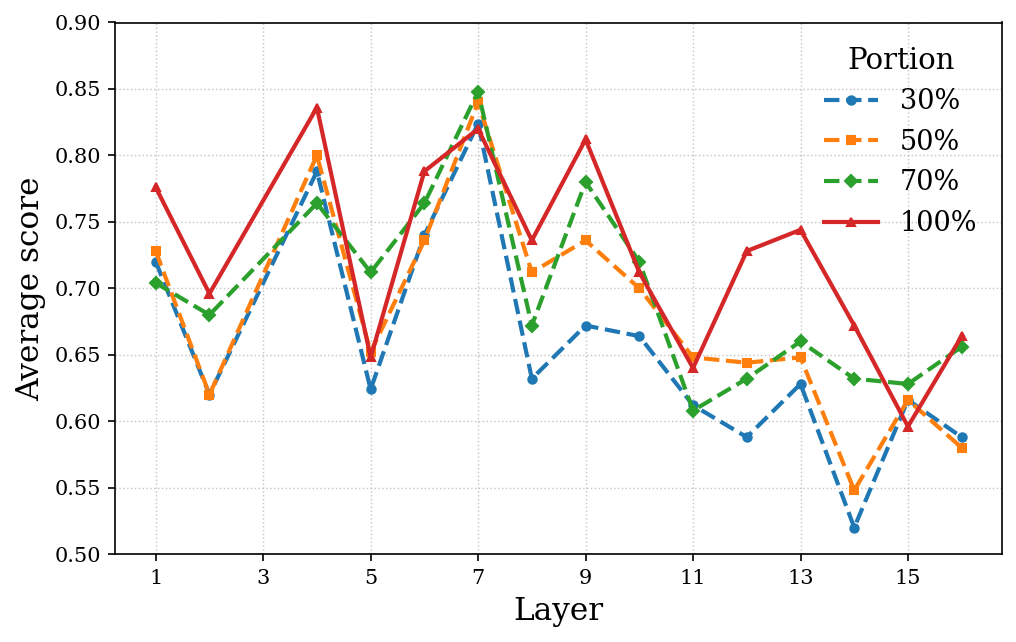

Saved figure to explainer_scores_vs_layer_sparsity.pdf


In [16]:
import matplotlib.pyplot as plt

# for nicer fonts in papers
plt.rcParams.update({
    "font.family": "serif",
    "font.size": 14,
    "axes.labelsize": 15,
    "axes.titlesize": 15,
    "legend.fontsize": 13,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "figure.dpi": 150,
})

# model keys in scores_dict
keys = [
    "explainer_L01_L16_30%_ckpt",
    "explainer_L01_L16_50%_ckpt",
    "explainer_L01_L16_70%_ckpt",
    "explainer_L01_L16_ckpt",       # interpret as 100%
]

labels = ["30%", "50%", "70%", "100%"]
markers = ["o", "s", "D", "^"]
linestyles = ["--", "--", "--", "-"]

# collect all layers to set x-ticks
all_layers = set()
for k in keys:
    all_layers.update(scores_dict[k].keys())
all_layers = sorted(all_layers)

fig, ax = plt.subplots(figsize=(7, 4.5))

for k, lbl, marker, ls in zip(keys, labels, markers, linestyles):
    m = scores_dict[k]
    layers = sorted(m.keys())
    y = [m[L] / 5.0 for L in layers]   # normalize to [0,1] as before

    ax.plot(
        layers,
        y,
        label=lbl,
        linewidth=2.0,
        marker=marker,
        markersize=4,
        linestyle=ls,
    )

ax.set_xlabel("Layer")
ax.set_ylabel("Average score")

ax.set_ylim(0.5, 0.9)

# integer ticks on x-axis
ax.set_xticks(range(min(all_layers), max(all_layers) + 1, 2))

ax.grid(True, linestyle=":", linewidth=0.7, alpha=0.7)
ax.legend(frameon=False, title="Portion")

fig.tight_layout()

output_path = "explainer_scores_vs_layer_sparsity.pdf"
fig.savefig(output_path, format="pdf", bbox_inches="tight")
plt.show()
plt.close(fig)
print(f"Saved figure to {output_path}")


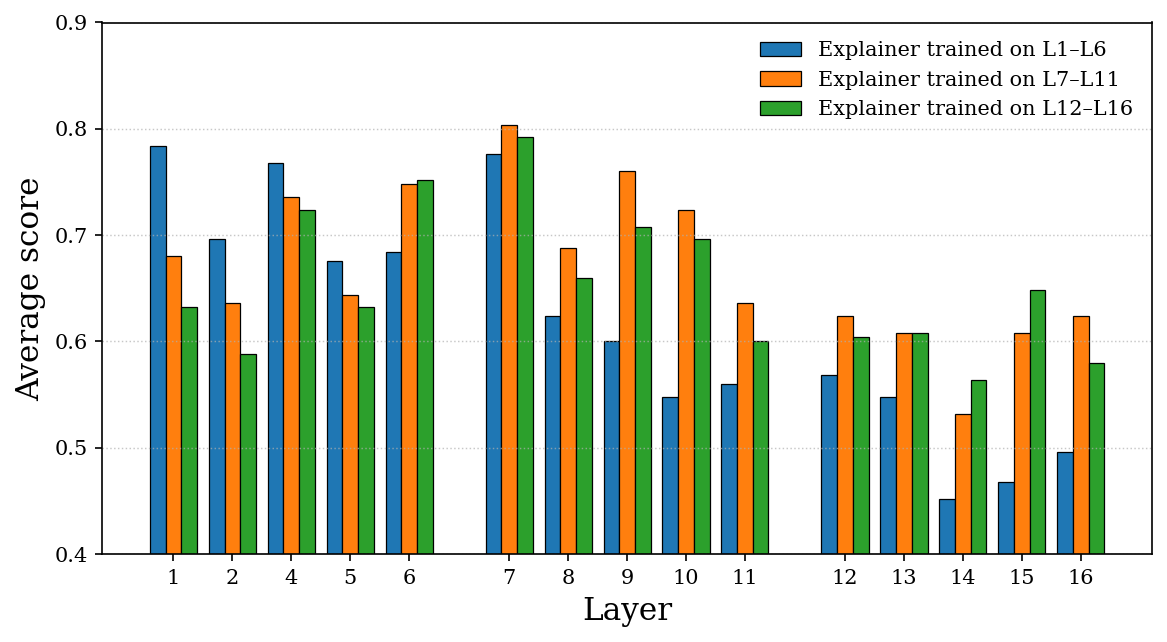

Saved figure to explainer_scores_barplot_layers_1_16_with_gaps.pdf


In [24]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams.update({
    "font.family": "serif",
    "font.size": 14,
    "axes.labelsize": 15,
    "axes.titlesize": 15,
    "legend.fontsize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "figure.dpi": 150,
})

models = [
    "explainer_L01_L06_ckpt",
    "explainer_L07_L11_ckpt",
    "explainer_L12_L16_ckpt",
]
labels = ["Explainer trained on L1–L6", "Explainer trained on L7–L11", "Explainer trained on L12–L16"]
colors = ["#1f77b4", "#ff7f0e", "#2ca02c"]  # blue, orange, green

# Collect all layers present in the three models
all_layers = set()
for m in models:
    all_layers.update(scores_dict[m].keys())
layers = sorted(all_layers)  # typically [1, 2, ..., 16]

# Build matrix of normalized scores [n_models x n_layers]
scores = []
for m in models:
    layer_scores = []
    for L in layers:
        if L in scores_dict[m]:
            layer_scores.append(scores_dict[m][L] / 5.0)  # normalize as before
        else:
            layer_scores.append(np.nan)  # or 0.0 if you prefer
    scores.append(layer_scores)

scores = np.array(scores)  # shape: (3, n_layers)

# --- Custom x positions with gaps after layer 6 and 11 ---
base_step = 1.0
gap_width = 0.7   # size of the visual gap; tune as you like

x_positions = []
for i, layer in enumerate(layers):
    x = i * base_step
    if layer >= 7:
        x += gap_width
    if layer >= 12:
        x += gap_width
    x_positions.append(x)

x = np.array(x_positions)

group_width = 0.8
bar_width = group_width / len(models)

fig, ax = plt.subplots(figsize=(8, 4.5))

for i, (lbl, color) in enumerate(zip(labels, colors)):
    ax.bar(
        x + (i - 1) * bar_width,   # centers three bars around each layer position
        scores[i],
        width=bar_width,
        label=lbl,
        edgecolor="black",
        linewidth=0.6,
        color=color,
    )

ax.set_xlabel("Layer")
ax.set_ylabel("Average score")

ax.set_xticks(x)
ax.set_xticklabels(layers)
ax.set_ylim(0.4, 0.9)

ax.grid(axis="y", linestyle=":", linewidth=0.7, alpha=0.7)
ax.legend(frameon=False)

fig.tight_layout()

output_path = "explainer_scores_barplot_layers_1_16_with_gaps.pdf"
fig.savefig(output_path, format="pdf", bbox_inches="tight")
plt.show()
plt.close(fig)
print(f"Saved figure to {output_path}")


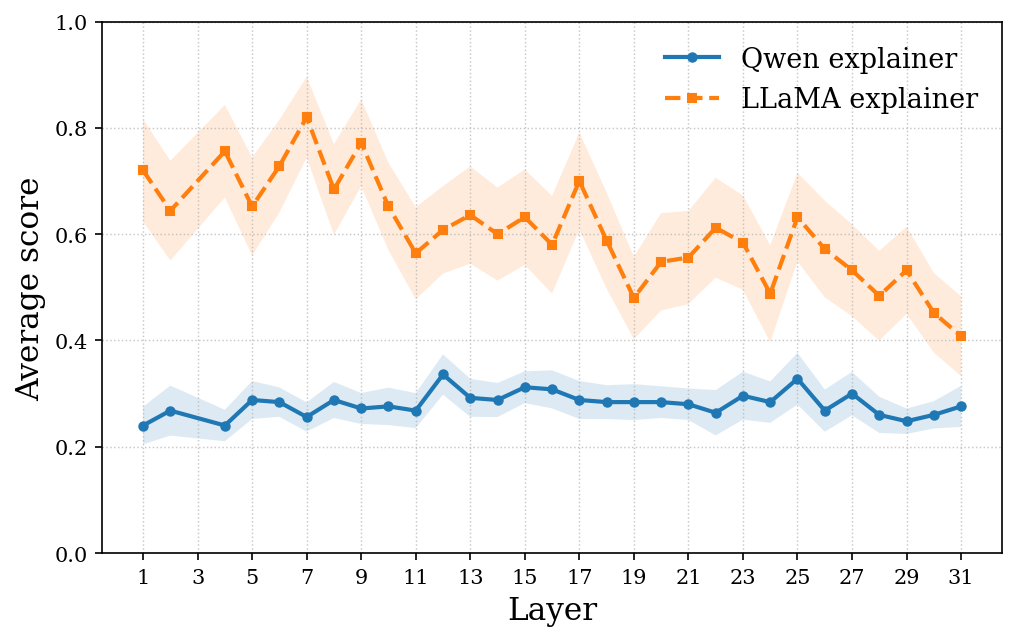

Saved figure to explainer_scores_vs_layer_with_CI.pdf


In [27]:
import os
import json
import math
from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt

# --------------------------------------------------------------------
# CONFIG
# --------------------------------------------------------------------
ROOT_DIR = "/mnt/raid10/ak-research-01/ak-research-01/codes/steer-vector/latentqa/1_feature_description/model"

# The two models to compare
MODEL_QWEN = "qwen_explainer_L01_L31_ckpt"
MODEL_LLAMA = "explainer_L01_L31_ckpt"

# --------------------------------------------------------------------
# COLLECT STATS (mean + SE) PER LAYER FOR EACH MODEL
# --------------------------------------------------------------------
def collect_layer_stats(model_name: str):
    """
    Read results/<model>/results.jsonl and compute:
        mean score and standard error per layer.

    Returns:
        stats: dict[layer] = {"mean": float, "se": float}
    """
    results_path = os.path.join(ROOT_DIR, model_name, "results", "results.jsonl")
    if not os.path.isfile(results_path):
        raise FileNotFoundError(f"No results.jsonl found for model {model_name}")

    layer_scores = defaultdict(list)

    with open(results_path, "r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            try:
                obj = json.loads(line)
            except json.JSONDecodeError:
                continue

            layer = obj.get("layer")
            score = obj.get("score")
            if layer is None or score is None:
                continue

            layer_scores[layer].append(float(score))

    stats = {}
    for layer, vals in layer_scores.items():
        arr = np.array(vals, dtype=float)
        mean = arr.mean()
        if len(arr) > 1:
            std = arr.std(ddof=1)
            se = std / math.sqrt(len(arr))
        else:
            se = 0.0
        stats[layer] = {"mean": mean, "se": se}

    return stats


stats_qwen = collect_layer_stats(MODEL_QWEN)
stats_llama = collect_layer_stats(MODEL_LLAMA)

# --------------------------------------------------------------------
# PREPARE PLOT DATA (normalize by 5 as before)
# --------------------------------------------------------------------
layers_qwen = sorted(stats_qwen.keys())
layers_llama = sorted(stats_llama.keys())
layers_all = sorted(set(layers_qwen) | set(layers_llama))

y_qwen = []
y_qwen_se = []
y_llama = []
y_llama_se = []

for L in layers_all:
    if L in stats_qwen:
        y_qwen.append(stats_qwen[L]["mean"] / 5.0)
        y_qwen_se.append(stats_qwen[L]["se"] / 5.0)
    else:
        y_qwen.append(np.nan)
        y_qwen_se.append(0.0)

    if L in stats_llama:
        y_llama.append(stats_llama[L]["mean"] / 5.0)
        y_llama_se.append(stats_llama[L]["se"] / 5.0)
    else:
        y_llama.append(np.nan)
        y_llama_se.append(0.0)

y_qwen = np.array(y_qwen)
y_qwen_se = np.array(y_qwen_se)
y_llama = np.array(y_llama)
y_llama_se = np.array(y_llama_se)

# 95% confidence interval: mean ± 1.96 * SE
ci_mult = 1.96
qwen_lower = y_qwen - ci_mult * y_qwen_se
qwen_upper = y_qwen + ci_mult * y_qwen_se
llama_lower = y_llama - ci_mult * y_llama_se
llama_upper = y_llama + ci_mult * y_llama_se

# --------------------------------------------------------------------
# PLOT
# --------------------------------------------------------------------
plt.rcParams.update({
    "font.family": "serif",
    "font.size": 14,
    "axes.labelsize": 15,
    "axes.titlesize": 15,
    "legend.fontsize": 13,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "figure.dpi": 150,
})

fig, ax = plt.subplots(figsize=(7, 4.5))

# Qwen line + CI
ax.plot(
    layers_all,
    y_qwen,
    label="Qwen explainer",
    linewidth=2.0,
    marker="o",
    markersize=4,
)
ax.fill_between(
    layers_all,
    qwen_lower,
    qwen_upper,
    alpha=0.15,
)

# LLaMA line + CI
ax.plot(
    layers_all,
    y_llama,
    label="LLaMA explainer",
    linewidth=2.0,
    marker="s",
    markersize=4,
    linestyle="--",
)
ax.fill_between(
    layers_all,
    llama_lower,
    llama_upper,
    alpha=0.15,
)

ax.set_xlabel("Layer")
ax.set_ylabel("Average score")

ax.set_ylim(0.0, 1.0)
ax.set_xticks(range(min(layers_all), max(layers_all) + 1, 2))

ax.grid(True, linestyle=":", linewidth=0.7, alpha=0.7)
ax.legend(frameon=False)

fig.tight_layout()

output_path = "explainer_scores_vs_layer_with_CI.pdf"
fig.savefig(output_path, format="pdf", bbox_inches="tight")
plt.show()
plt.close(fig)
print(f"Saved figure to {output_path}")
